In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [2]:
img_path = "processed_images/IMG_1.jpg"
points_path = "processed_points/IMG_1.npy"
density_path = "density_maps/IMG_1.npy"

img = cv2.imread(img_path)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

points = np.load(points_path)
density = np.load(density_path)

In [3]:
img_points = img_rgb.copy()

for x, y in points:
    cv2.circle(img_points, (int(x), int(y)), 3, (255, 0, 0), -1)

In [4]:
heatmap = cv2.applyColorMap((density / density.max() * 255).astype(np.uint8), cv2.COLORMAP_JET)
heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)

overlay = cv2.addWeighted(img_rgb, 0.6, heatmap, 0.4, 0)

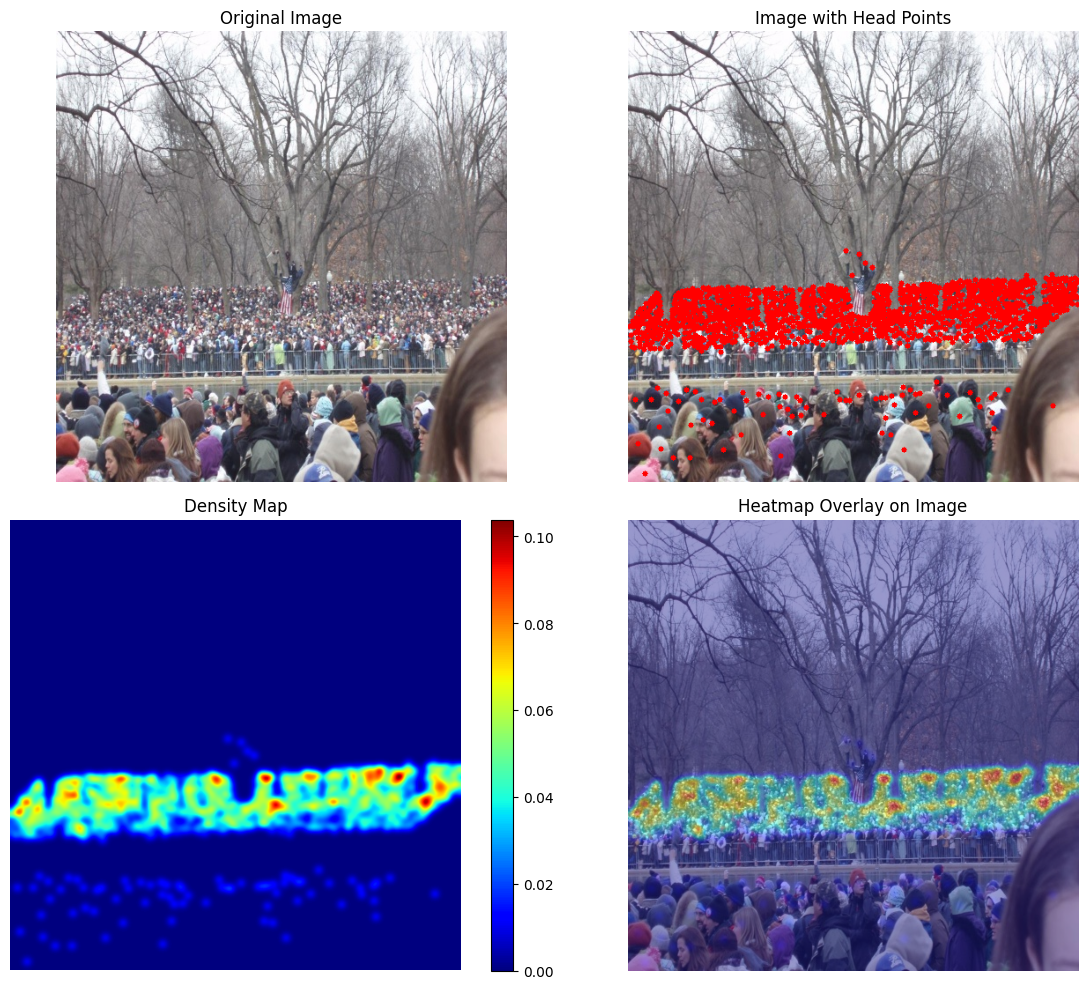

In [5]:
plt.figure(figsize=(12, 10))

plt.subplot(2, 2, 1)
plt.imshow(img_rgb)
plt.title("Original Image")
plt.axis("off")

plt.subplot(2, 2, 2)
plt.imshow(img_points)
plt.title("Image with Head Points")
plt.axis("off")

plt.subplot(2, 2, 3)
plt.imshow(density, cmap="jet")
plt.title("Density Map")
plt.colorbar()
plt.axis("off")

plt.subplot(2, 2, 4)
plt.imshow(overlay)
plt.title("Heatmap Overlay on Image")
plt.axis("off")

plt.tight_layout()
plt.show()


In [2]:
import torch
import numpy as np
import cv2
import matplotlib.pyplot as plt

#### Loading sample tensor pair

In [3]:
IMG_DIR = "processed_images"
DENSITY_DIR = "density_maps"

sample_name = "IMG_1.jpg"

# Load image (RGB)
img = cv2.imread(f"{IMG_DIR}/{sample_name}")
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Load density map
density = np.load(f"{DENSITY_DIR}/{sample_name.replace('.jpg', '.npy')}")

#### Downsample and Scale Density

In [4]:
density_down = cv2.resize(density, (density.shape[1]//8, density.shape[0]//8))
density_down = density_down * 64  # preserve count

#### convert to tensors

In [5]:
from torchvision import transforms

transform = transforms.Compose([
    transforms.ToTensor(),  
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

img_tensor = transform(img_rgb)                 # shape [3,512,512]
density_tensor = torch.tensor(density_down).unsqueeze(0)  # shape [1,64,64]

print("Image tensor shape:", img_tensor.shape)
print("Density tensor shape:", density_tensor.shape)
print("GT People Count:", density_tensor.sum().item())

Image tensor shape: torch.Size([3, 512, 512])
Density tensor shape: torch.Size([1, 64, 64])
GT People Count: 1547.1380615234375


#### Visualization comparing processed items

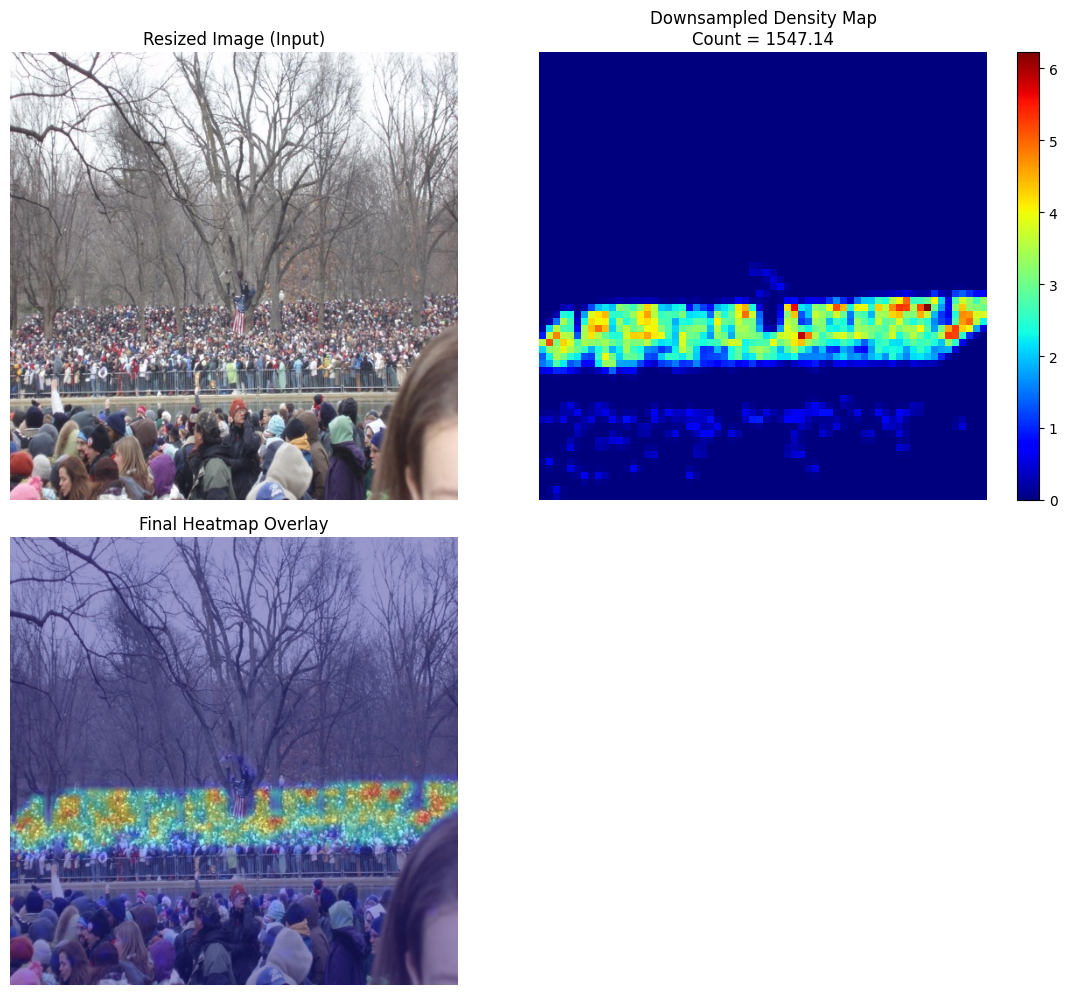

In [7]:
plt.figure(figsize=(12,10))

plt.subplot(2,2,1)
plt.imshow(img_rgb)
plt.title("Resized Image (Input)")
plt.axis("off")

plt.subplot(2,2,2)
plt.imshow(density_down, cmap="jet")
plt.title(f"Downsampled Density Map\nCount = {density_down.sum():.2f}")
plt.colorbar()
plt.axis("off")

plt.subplot(2,2,3)
heatmap = cv2.applyColorMap((density_down / density_down.max() * 255).astype(np.uint8),
                            cv2.COLORMAP_JET)
heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)

# resize heatmap to original image size
heatmap_resized = cv2.resize(heatmap, (img_rgb.shape[1], img_rgb.shape[0]))
overlay = cv2.addWeighted(img_rgb, 0.6, heatmap_resized, 0.4, 0)

plt.imshow(overlay)
plt.title("Final Heatmap Overlay")
plt.axis("off")

plt.tight_layout()
plt.show()